In [15]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [9]:
warpSize = 32
# eccentricity Adams and Horton 2003 Fig.4
Ap = 9.5
Bp = 0.95
Pp = -1.03
Ae = 188
Be = 6.45
Pe = -1.85
E0 = 0.0
# traveling wave at eccentricity of 1.8 and 3.4 deg, Wilson et al 2001 Nat
max_ecc = 2 #deg 
E1 = max_ecc
vertical_slice = lambda E: 180*Ap*(E+Bp)**Pp*Be*(E+Be)**Pe # mm^2/deg
result = integrate.quad(vertical_slice,E0,E1) # mm^2
area = ((int(result[0])+warpSize-1)//warpSize) * warpSize

In [10]:
import math
## O'Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
surface_den_L4Cbeta = 32768 # per mm^2
n_L4Cbeta = area*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
surface_den_L23 = 20480 # per mm^2
n_L23 = area*surface_den_L23
print(n_L4Cbeta, n_L23)

10485760 6553600


In [11]:
# for test 1/80 of final size
from macaque_fovea import *

taking up 24.0001220703125 Mb
area = 320.0 area per block = 0.3125
characteristic_length, cl = 0.559016994375
24 1000
cos(theta) of 0.9908301680442989
modulus of ring =  -0.163683550549
corrected cl =  0.560638653288 nring = 26
avg iterations = 6.461538461538462
avg biterations = 12.0
1000 blocks constructed
upper estimate 10 stripes
#6 limited to 1.9999999999999076
6 12.0 24
------- 0 0
[-3.78697898 -2.92818178 -2.83443895]
[-3.78697898 -2.83443895]
[ 0.71296844 -0.        ] [ 0. -0.]
[ 0.7203589  -0.43156351] [ 0.01624556 -0.44685705]
------- 1 0
[-2.92818178 -2.5265903  -2.41857875]
[-2.92818178 -2.83443895 -2.41857875]
[ 1.39311374 -2.41857875] [ 0.54259333 -2.5265903 ]
[ 1.37000389 -2.83443895] [ 0.74130829 -2.92818178]
------- 2 0
[-2.5265903  -1.90630563 -1.85452875]
[-2.5265903  -2.47357033 -1.85452875]
[ 0.85148714 -1.85452875] [ 0.30270796 -1.90630563]
[ 0.96009094 -2.47357033] [ 0.54259333 -2.5265903 ]
------- 2 1
[-2.47357033 -1.85452875 -1.80082649]
[-2.47357033 -2.4185787

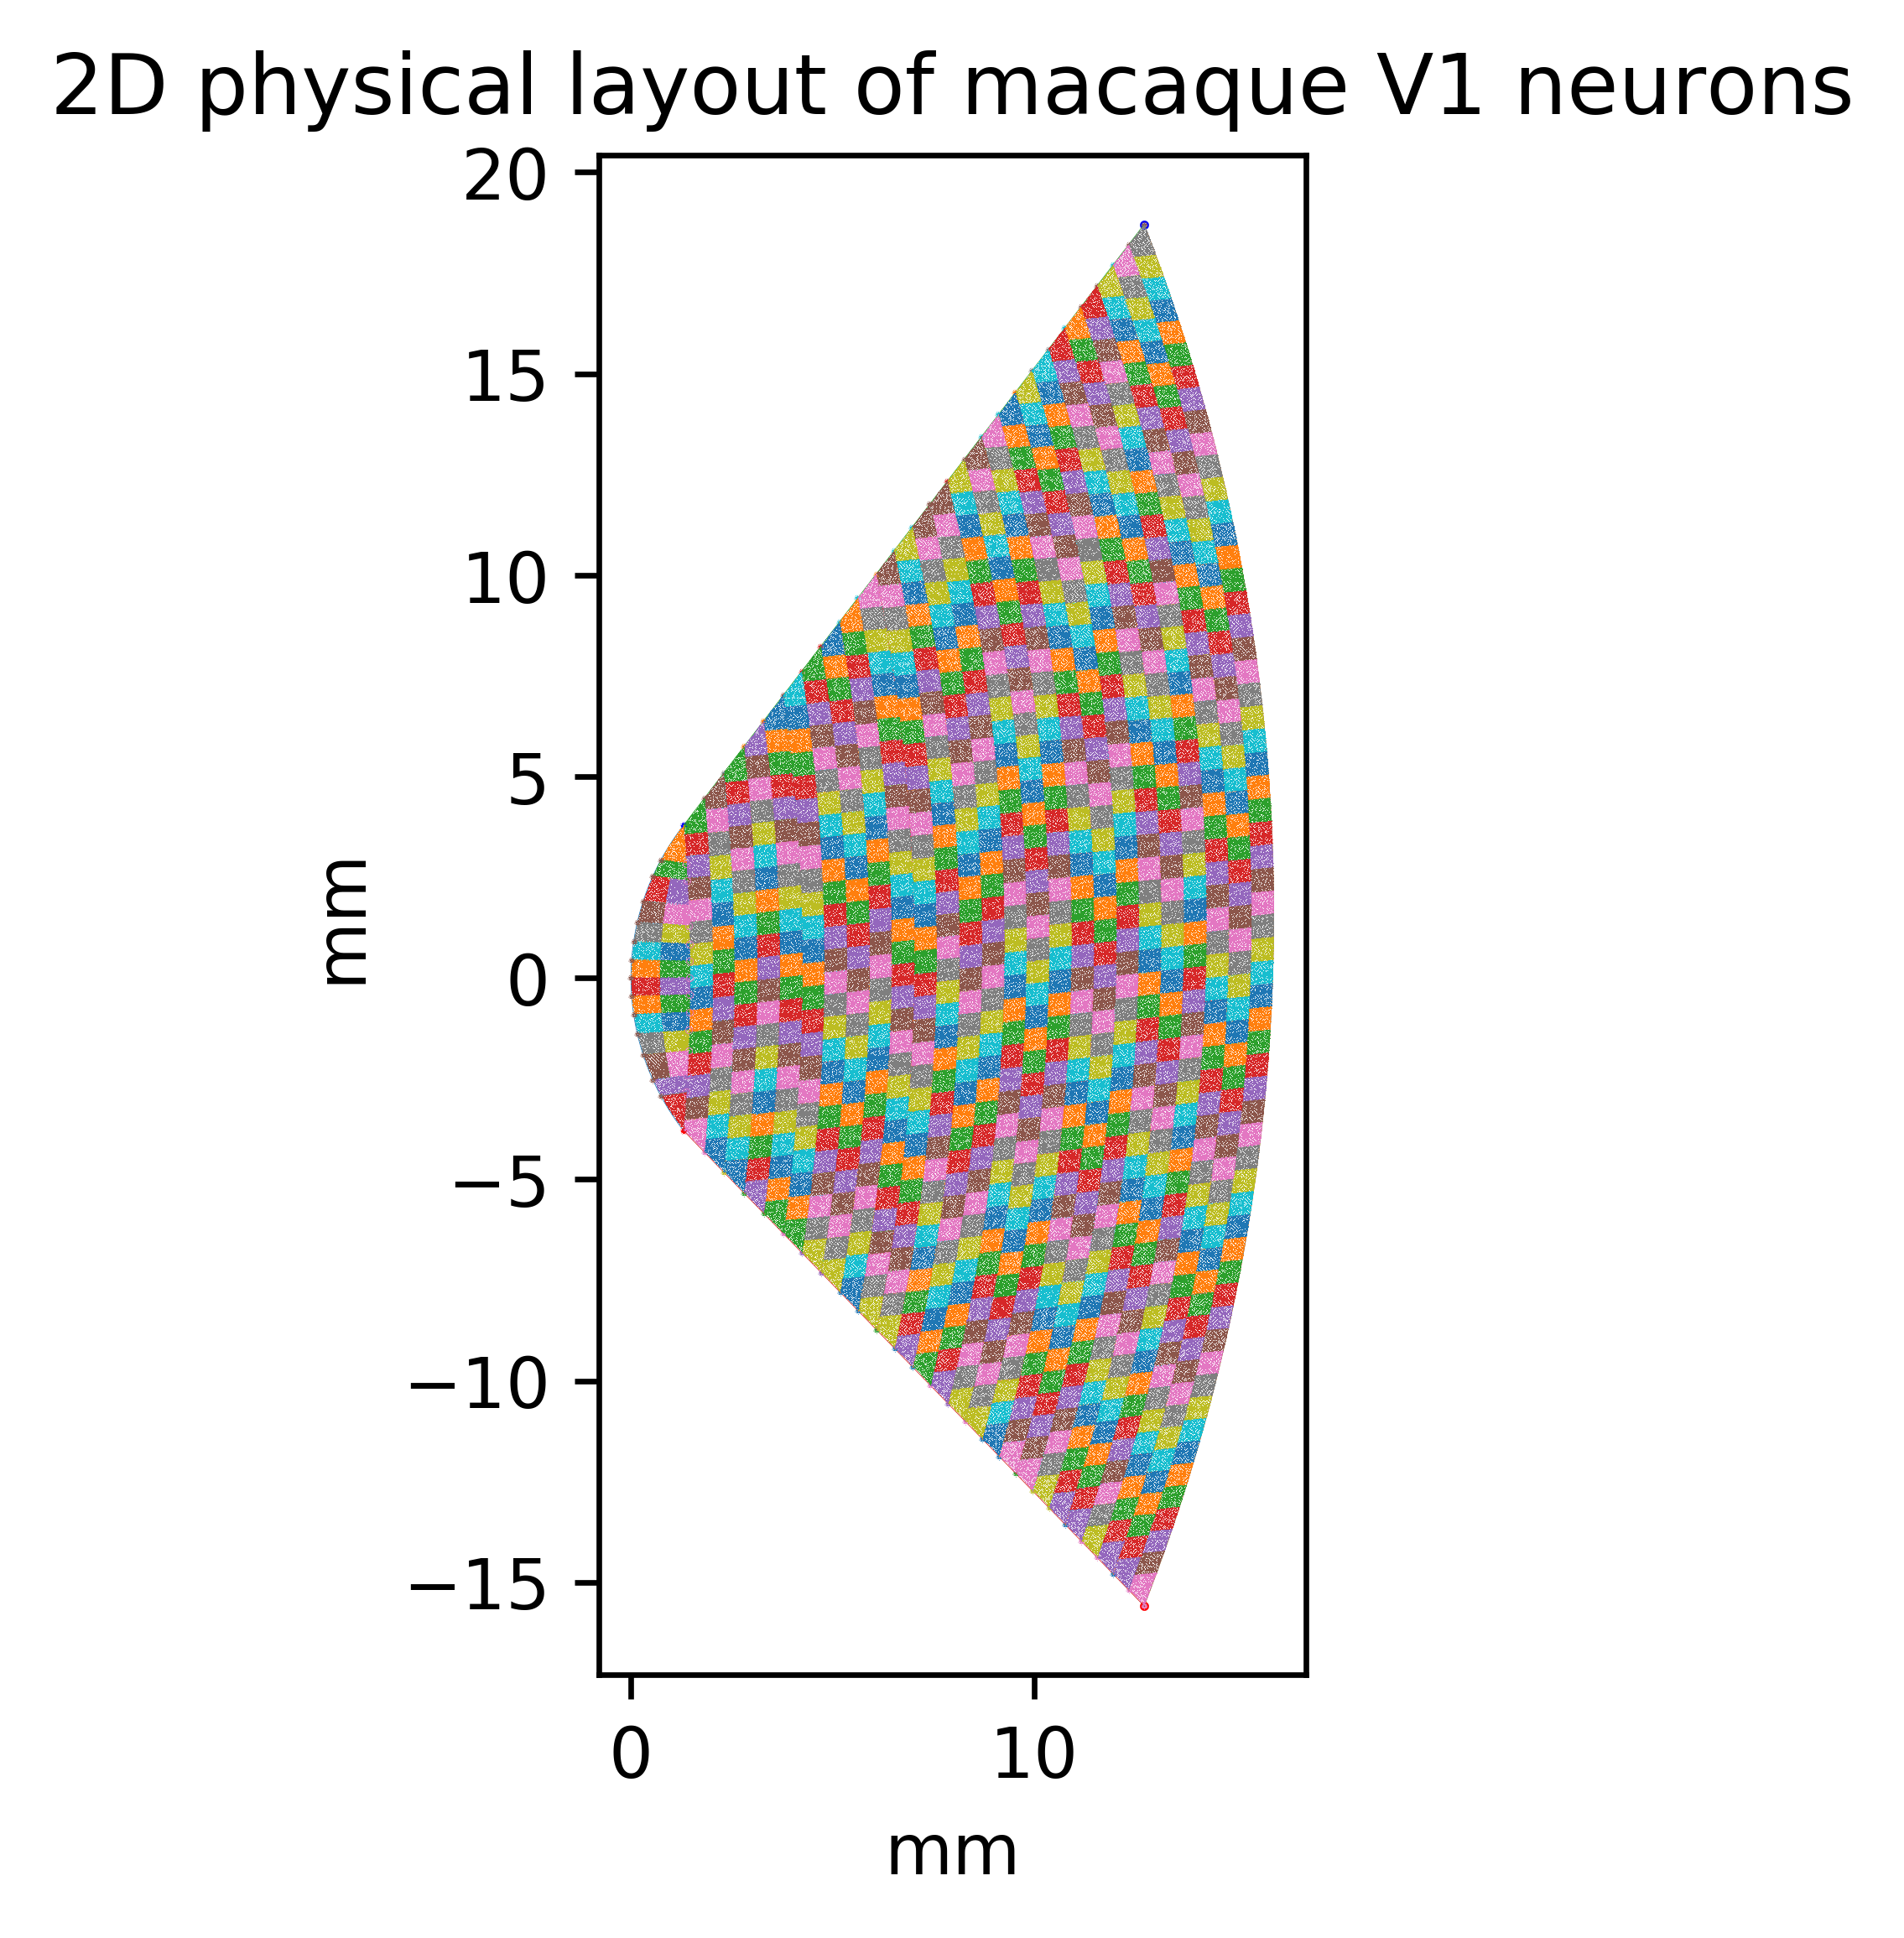

In [18]:
nblock = 1024
neuron_per_block = 1024
seed = 34576823
pos, fig = construct_macaque_fovea(area, nblock, neuron_per_block, seed, use_sobol3d=True) #sobol3d is cpu-implemented, slow

In [19]:
fig.savefig('sparse_1_10_shape.png', dpi = 600)

In [20]:
pos.tofile('1-10th_macaque_fovea_v1_3d_pos.bin')

In [21]:
nblock = 10240
neuron_per_block = 1024
seed = 34576823

taking up 240.0001220703125 Mb
area = 320.0 area per block = 0.03125
characteristic_length, cl = 0.176776695297
240 10000
cos(theta) of 0.9908301680442989
modulus of ring =  -0.29839367086
corrected cl =  0.177763475433 nring = 82
avg iterations = 5.951219512195122
avg biterations = 10.890243902439025
10000 blocks constructed
upper estimate 26 stripes
#21 limited to 6.999999999999048
21 120.0 240
avg iterations 7.0476190476190474
10240 constructed


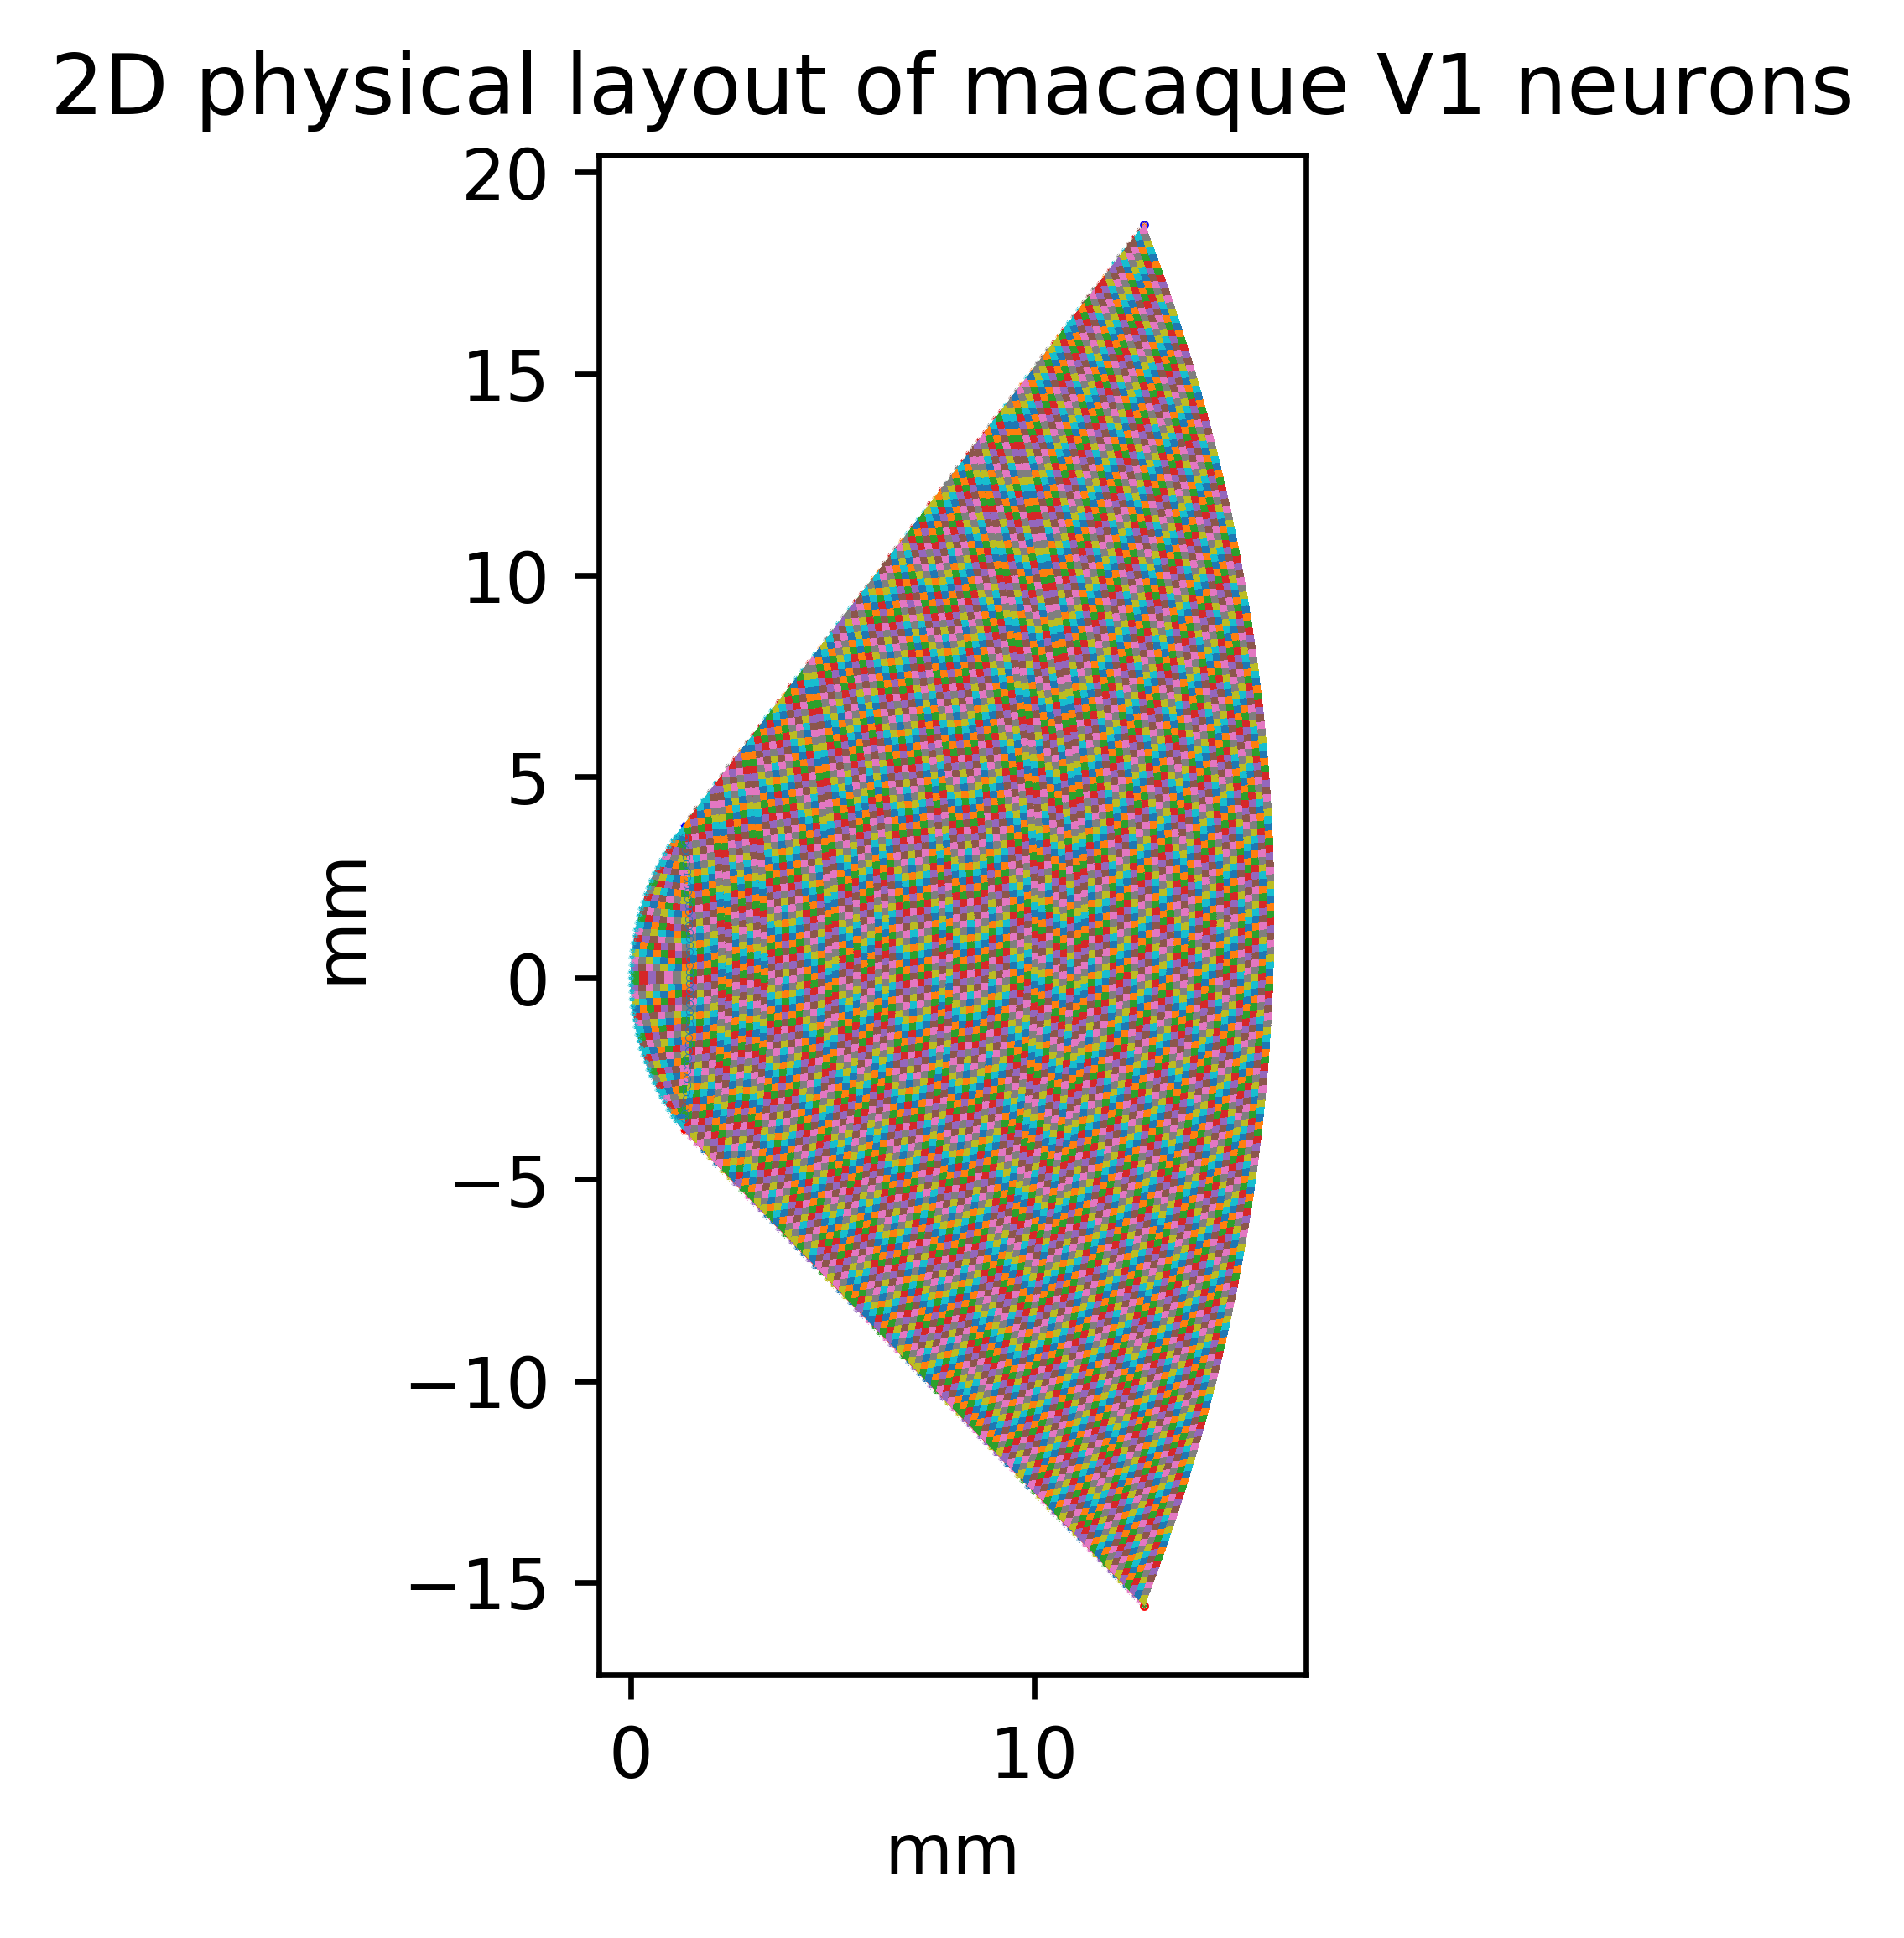

In [22]:
pos, fig = construct_macaque_fovea(area, nblock, neuron_per_block, seed, use_sobol3d=True)

In [ ]:
pos.tofile('full_macaque_fovea_v1_3d_pos.bin')

In [ ]:
fig.savefig('shape.png', dpi = 600)

characteristic length =

In [20]:
cl = np.sqrt(area_CMF/10240) * 1000
print(cl)

176.7766952966369


~177x177x100 $\mu m^3$ (1024 neurons) per block, average inter-neuron(soma)-distance =

In [22]:
md = np.power(cl*cl*100/1024,1/3)
print(md)

14.504965105039933


conduction velocity ~ 1m/s, being unmylineated horizontal connections  
(0.3m/s for L2/3 and upper L4) <i>Girard et al J Neurophysiol 2001</i>  
minmum delay = 0.0145ms, no spike-correction is needed for time step (dt) < minimum delay
100Hz instantaneous firing rate, 1000 connections leads to ~ 100 spikes per time step, an effective dt of 0.01ms regardless of preset dt

In [24]:
nob = 1000/cl
print(nob)

5.65685424949238


dt = 1ms means neurons in the nearest 5~6 blocks needs to be considered for spike correction  
dt = 0.125ms (1/8) suffice for spike correction within block, #ASSUMPTION# nearfield spike correction only (neurons at block boundarys are neglected) spikes send to the other blocks are resolved after the current step.

#dt = 0.125ms is thus limited by the number of threads per block in NVIDIA GPU  
To further increase dt, will need a cross block spike-correction with CPU, or wait for an update from NVIDIA, otherwise results in an extra increase in spike-correction error, maybe tolerable.

In [34]:
time = 500
dt = 0.0625
batch_time_per_dt = 500e-6 #sec
nstep = time//dt
blocks = 10240
resident_blocks = 8
time_cost = np.int(blocks/resident_blocks) * batch_time_per_dt * nstep
print('simulate for', time ,'ms with dt =', dt, 'ms cost', time_cost/3600,'h')

simulate for 500 ms with dt = 0.0625 ms cost 1.4222222222222223 h


In [10]:
import sobol_seq as ss

In [39]:
pos = np.fromfile('full_macaque_fovea_v1_3d_pos.bin')

In [42]:
pos = np.reshape(pos,(3,nblock,neuron_per_block))

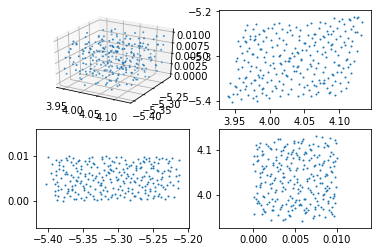

In [45]:
a = pos[:,1023,:].T
from mpl_toolkits.mplot3d import Axes3D
p0 = 768
p1 = 1024
fig = plt.figure('x')
ax = fig.add_subplot(221, projection='3d')
ax.scatter(a[p0:p1,0],a[p0:p1,1],a[p0:p1,2],s=1,zdir='z')
ax = fig.add_subplot(222)
ax.scatter(a[p0:p1,0],a[p0:p1,1], s=1)
ax = fig.add_subplot(223)
ax.scatter(a[p0:p1,1],a[p0:p1,2], s=1)
ax = fig.add_subplot(224)
ax.scatter(a[p0:p1,2],a[p0:p1,0], s=1)

In [1]:
def area(raxn, rden, d):
    area = np.zeros(d.size)
    minr = max(raxn,rden) - min(raxn,rden)
    maxr = max(raxn,rden) + min(raxn,rden)
    area[d <= minr] = np.power(min(raxn,rden),2)*np.pi
    mid_pick = np.logical_and(minr < d, d < maxr)
    d_mid = d[mid_pick]
    cos_theta_axn = (raxn*raxn + d_mid*d_mid - rden*rden)/(2*raxn*d_mid)
    cos_theta_den = (rden*rden + d_mid*d_mid - raxn*raxn)/(2*rden*d_mid)
    seg_axn = np.arccos(cos_theta_axn)*raxn*raxn
    seg_den = np.arccos(cos_theta_den)*rden*rden

    chord_axn = np.sqrt(raxn*raxn - np.power(cos_theta_axn*raxn,2)) * raxn * cos_theta_axn
    chord_den = np.sqrt(rden*rden - np.power(cos_theta_den*rden,2)) * rden * cos_theta_den
    area[mid_pick] = seg_axn+seg_den-chord_axn-chord_den
    assert(np.sum(area<0) == 0)
    return area
                                    
def base(raxn, rden, d):
    #subr = d-raxn
    #subr[subr<0] = 0
    #supr = d+raxn
    #supr[supr>rden] = rden
    #base = np.pi*(np.power(supr,2) - np.power(subr,2))
    base = np.pi*(np.power(raxn,2))
    return base

(12.5, 150.0)

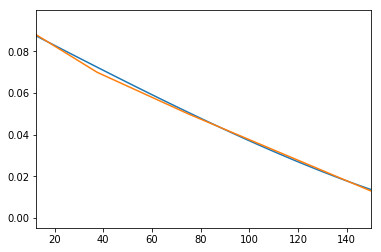

In [5]:
raxn = 100 #um
rden = 100
nd = 100
dd = (raxn+rden)/nd
dee = np.linspace(0,raxn+rden-dd,nd-1)

fig = plt.figure('prob')
ax = fig.add_subplot(111)
ratio = 0.095
ax.plot(dee,  area(raxn,rden,dee)/base(raxn,rden,dee)*ratio)
x = np.array([12.5, 37.5, 75, 150])
y = np.array([8.8, 7.0, 5.0, 1.3])/100
ax.plot(x,y)
ax.set_xlim(x[0],x[-1])

(12.5, 75)

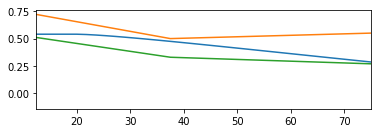

In [6]:
raxn = 100
rden = 80
nd = 100
dd = (raxn+rden)/nd
dii = np.linspace(0, raxn+rden-dd,nd-1)
fig = plt.figure('prob')
ax = fig.add_subplot(211)
y = area(raxn,rden,dii)/base(raxn,rden,dii)
baseline = -0.1
ratio = 1
ax.plot(dii,y*ratio+baseline)
x = [12.5, 37.5, 75]
y = [0.72, 0.50, 0.55]
yr = [0.51, 0.33, 0.27]
ax.plot(x,y)
ax.plot(x,yr)
ax.set_xlim(x[0],x[-1])

3.1415926535897931

In [101]:
0.075/0.3

0.25